In [1]:
#import our beautiful packages
import csv
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
import statistics

# collect list of breast videos

In [2]:
%cd /pasteur/u/egoodma/data/videos/breast

/pasteur/u/egoodma/data/videos/breast


In [3]:
%%bash
rm breast_names.txt
for entry in *
do
  echo "$entry" >> breast_names.txt
done

In [4]:
with open("breast_names.txt") as f:
    breast_videos = f.readlines()
breast_videos = [x.strip() for x in breast_videos]
breast_videos = [vid for vid in breast_videos if len(vid) == 15]
breast_videos = set(breast_videos)
print("Studying {} breast videos".format(len(breast_videos)))

Studying 128 breast videos


# collect list of gastro videos

In [5]:
%cd /pasteur/u/egoodma/data/videos/gastro

/pasteur/u/egoodma/data/videos/gastro


In [6]:
%%bash
rm gastro_names.txt
for entry in *
do
  echo "$entry" >> gastro_names.txt
done

In [7]:
with open("gastro_names.txt") as f:
    gastro_videos = f.readlines()
gastro_videos = [x.strip() for x in gastro_videos]
gastro_videos = [vid for vid in gastro_videos if len(vid) == 15]
gastro_videos = set(gastro_videos)

# collect list of head videos

In [8]:
%cd /pasteur/u/egoodma/data/videos/head

/pasteur/u/egoodma/data/videos/head


In [9]:
%%bash
rm head_names.txt
for entry in *
do
  echo "$entry" >> head_names.txt
done

In [10]:
with open("head_names.txt") as f:
    head_videos = f.readlines()
head_videos = [x.strip() for x in head_videos]
head_videos = [vid for vid in head_videos if len(vid) == 15]
head_videos = set(head_videos)

# analysis now with data!

In [11]:
print("Analyzing {} breast videos, {} gastro videos, and {} head videos".format(len(breast_videos), len(gastro_videos), len(head_videos)))

Analyzing 128 breast videos, 155 gastro videos, and 54 head videos


In [12]:
###############################################################
#this creates sequence_dict, mapping videos to sequences      #
#sequence_dict[video] = ["cutting", "cutting", ... "suturing"]#
#this also create label_dict, mapping videos to class labels  #
#label_dict[video] = 1                                        #
###############################################################
%cd /pasteur/u/egoodma/surgery-action-recognition

sequence_dict = dict()
label_dict = dict()

with open('v0.6.0-preds.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    next(readCSV)
    rows = 0
    for row in readCSV:
        rows += 1
        movie_name = row[0]
        if movie_name not in sequence_dict:
            sequence_dict[movie_name] = []
            if movie_name+'.mp4' in breast_videos:
                label_dict[movie_name] = 0
            elif movie_name+'.mp4' in gastro_videos:
                label_dict[movie_name] = 1
            elif movie_name+'.mp4' in head_videos:
                label_dict[movie_name] = 2
            else:
                print("Couldn't find movie!!!")
                break
        for i in range(int(int(row[1])/5)):
            sequence_dict[movie_name].append(row[2])
        
        
############################################################
#creates action_dict, another representation of a video    #
#this moves from action to action, and is paired with      #
#time-dict, the corresponding duration of the action (secs)# 
############################################################

#background = 0, cutting = 1, suturing = 2, tying = 3
time_dict = dict()
action_dict = dict()
for video in sequence_dict:
    time_dict[video] = [5]
    action_dict[video] = [sequence_dict[video][0]]
    #print("Studying video {}".format(video))
    for t in range(1, len(sequence_dict[video])):
        if sequence_dict[video][t] == action_dict[video][-1]:
            time_dict[video][-1] += 5
        else:
            action_dict[video].append(sequence_dict[video][t])
            time_dict[video].append(5)
               
for video in action_dict:
    total_time = sum(time_dict[video])
    for i, action in enumerate(action_dict[video]):
        if action == "background":
            action_dict[video][i] = 0
        elif action == "cutting":
            action_dict[video][i] = 1
        elif action == "suturing":
            action_dict[video][i] = 2
        elif action == "tying":
            action_dict[video][i] = 3
        time_dict[video][i] /= total_time
        
####################################
#now we will show a couple examples#                         
####################################
print(sequence_dict["bxm902jT1Ok"])
print(label_dict["bxm902jT1Ok"])
print(action_dict["bxm902jT1Ok"])
print(time_dict["bxm902jT1Ok"])

/pasteur/u/egoodma/surgery-action-recognition
['background', 'background', 'cutting', 'background', 'background', 'background', 'background', 'background', 'background', 'cutting', 'background', 'background', 'background', 'cutting', 'background', 'background', 'cutting', 'background', 'cutting', 'cutting', 'background', 'background', 'cutting', 'cutting', 'cutting', 'cutting', 'cutting', 'cutting', 'cutting', 'cutting', 'cutting', 'background', 'background', 'cutting', 'cutting', 'cutting', 'cutting', 'background']
1
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
[0.05263157894736842, 0.02631578947368421, 0.15789473684210525, 0.02631578947368421, 0.07894736842105263, 0.02631578947368421, 0.05263157894736842, 0.02631578947368421, 0.02631578947368421, 0.05263157894736842, 0.05263157894736842, 0.23684210526315788, 0.05263157894736842, 0.10526315789473684, 0.02631578947368421]


Breast complexity 15.89090909090909, gastro complexity 20.968992248062015, head complexity 23.1875
Breast complexity 13.959907172487316, gastro complexity 17.833831617104238, head complexity 18.437570621333677


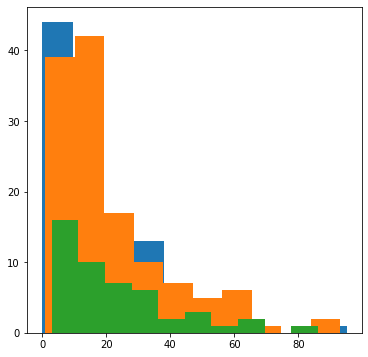

In [13]:
#############################################################
#now we want to get the 'complexity' of each action         #
#to see if certain types of surgeries are more complex      #
#we define complexity as times swapped between tasks        #
#############################################################
breast_complexity, gastro_complexity, head_complexity = [], [], []
for video in action_dict:
    if video+".mp4" in breast_videos:
        breast_complexity.append(len(action_dict[video]) - 1)
    elif video+".mp4" in gastro_videos:
        gastro_complexity.append(len(action_dict[video]) - 1)
    elif video+".mp4" in head_videos:
        head_complexity.append(len(action_dict[video]) - 1)
        
print("Breast complexity {}, gastro complexity {}, head complexity {}"\
      .format(np.mean(breast_complexity), np.mean(gastro_complexity), np.mean(head_complexity)))
print("Breast complexity {}, gastro complexity {}, head complexity {}"\
      .format(np.std(breast_complexity), np.std(gastro_complexity), np.std(head_complexity)))

plt.figure(figsize=(6, 6))
_ = plt.hist(breast_complexity, 10)
_ = plt.hist(gastro_complexity, 10)
_ = plt.hist(head_complexity, 10)

[0.38181818 0.40909091 0.17272727 1.40909091 0.4        0.94545455
 4.60909091 0.89090909 0.60909091 4.41818182 0.57272727 1.07272727] is breast representation
[0.84496124 0.74418605 0.52713178 3.24031008 0.75193798 2.40310078
 4.20930233 1.20155039 0.90697674 3.95348837 0.6124031  1.57364341] is gastro representation
[0.70833333 1.10416667 0.5        1.60416667 1.14583333 1.33333333
 6.83333333 0.77083333 0.89583333 6.60416667 0.64583333 1.04166667] is head representation






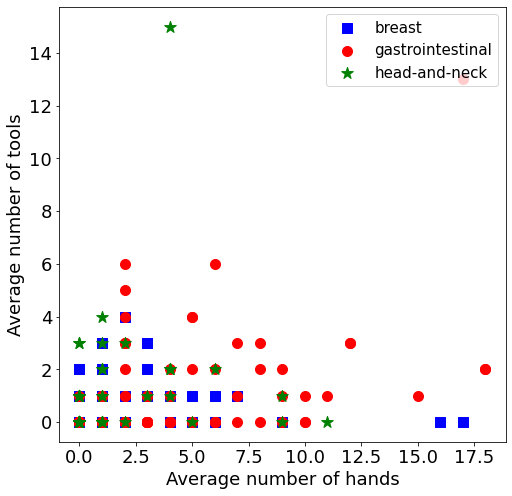

In [14]:
#############################################################
#now we want to get the transition types of surgeries       #
#############################################################


def analyze_video(video, sequence_dict):
    video_rep = [0]*12
    for i in range(len(sequence_dict[video]) - 1):
        if sequence_dict[video][i] == "cutting" and sequence_dict[video][i+1] == "suturing":
            video_rep[0] += 1
        if sequence_dict[video][i] == "cutting" and sequence_dict[video][i+1] == "tying":
            video_rep[1] += 1
        if sequence_dict[video][i] == "suturing" and sequence_dict[video][i+1] == "cutting":
            video_rep[2] += 1
        if sequence_dict[video][i] == "suturing" and sequence_dict[video][i+1] == "tying":
            video_rep[3] += 1
        if sequence_dict[video][i] == "tying" and sequence_dict[video][i+1] == "cutting":
            video_rep[4] += 1
        if sequence_dict[video][i] == "tying" and sequence_dict[video][i+1] == "suturing":
            video_rep[5] += 1
        if sequence_dict[video][i] == "background" and sequence_dict[video][i+1] == "cutting":
            video_rep[6] += 1
        if sequence_dict[video][i] == "background" and sequence_dict[video][i+1] == "suturing":
            video_rep[7] += 1
        if sequence_dict[video][i] == "background" and sequence_dict[video][i+1] == "tying":
            video_rep[8] += 1
        if sequence_dict[video][i] == "cutting" and sequence_dict[video][i+1] == "background":
            video_rep[9] += 1
        if sequence_dict[video][i] == "suturing" and sequence_dict[video][i+1] == "background":
            video_rep[10] += 1
        if sequence_dict[video][i] == "tying" and sequence_dict[video][i+1] == "background":
            video_rep[11] += 1
    if sum(video_rep) == 0:
        return [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    return [x / 1 for x in video_rep]

breast_trans, gastro_trans, head_trans = [], [], []
for video in action_dict:
    video_rep = analyze_video(video, sequence_dict)
    if video+".mp4" in breast_videos:
        breast_trans.append(video_rep)
    elif video+".mp4" in gastro_videos:
        gastro_trans.append(video_rep)
    elif video+".mp4" in head_videos:
        head_trans.append(video_rep)

breast_trans = np.asarray(breast_trans)
gastro_trans = np.asarray(gastro_trans)
head_trans = np.asarray(head_trans)

print(np.mean(breast_trans, axis = 0), "is breast representation")
print(np.mean(gastro_trans, axis = 0), "is gastro representation")
print(np.mean(head_trans, axis = 0), "is head representation")
print("\n\n\n")

#cutting->suturing in 0
#cutting->tying in 1
#suturing->cutting in 2
#suturing->tying in 3
#tying->cutting in 4
#tying->cutting in 5

###############################
#plotting numhands vs numtools#
###############################

fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111)
ax1.scatter(breast_trans[:, 3], breast_trans[:, 4], s=100, c='b', marker="s")
ax1.scatter(gastro_trans[:, 3], gastro_trans[:, 4], s=100, c='r', marker="o")
ax1.scatter(head_trans[:, 3], head_trans[:, 4], s=150, c='g', marker="*")
plt.xlabel('Average number of hands', fontsize=18)
plt.ylabel('Average number of tools', fontsize=18)

plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=18)

plt.legend(('breast', 'gastrointestinal', 'head-and-neck'),
           loc='upper right', prop={'size': 15})

In [15]:
x = np.concatenate((breast_trans, gastro_trans, head_trans), axis = 0)
y = np.concatenate((np.zeros((breast_trans.shape[0], 1)), np.ones((gastro_trans.shape[0], 1)), \
                    2*np.ones((head_trans.shape[0], 1))), axis = 0)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=102)

print("X_train {}, X_test {}, y_train {}, y_test {}"\
      .format(X_train.shape,  X_test.shape, y_train.shape, y_test.shape))

clf_cv = LogisticRegressionCV(penalty = "l1", solver="liblinear", cv=10, random_state = 10, max_iter = 1000).fit(X_train, y_train.ravel())

y_train_pred = clf_cv.predict(X_train)
print("Accurate percentage is", sum(y_train_pred==y_train.squeeze())/len(y_train_pred) * 100 , '\n')
print("Coefficients are", clf_cv.coef_)
y_test_pred = clf_cv.predict(X_test)
print("Accurate percentage is", sum(y_test_pred==y_test.squeeze())/len(y_test) * 100 )

X_train (229, 12), X_test (58, 12), y_train (229, 1), y_test (58, 1)
Accurate percentage is 51.96506550218341 

Coefficients are [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.11021807  0.          0.
   0.          0.          0.         -0.06110508  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]]
Accurate percentage is 60.3448275862069


In [16]:
#############################################################
#lets try and use deep learning to classify these surgeries!#
#############################################################

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


print("X_train {}, X_test {}, y_train {}, y_test {}"\
      .format(X_train.shape,  X_test.shape, y_train.shape, y_test.shape))
X_train_torch = torch.from_numpy(X_train).float()
X_test_torch = torch.from_numpy(X_test).float()
y_train_torch = torch.from_numpy(y_train.reshape((-1,))).long()
y_test_torch = torch.from_numpy(y_test.reshape((-1,))).long()


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(12, 30)
        self.fc2 = nn.Linear(30, 3)
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x
    
my_nn = Net()
criterion = nn.NLLLoss()
optimizer = optim.SGD(my_nn.parameters(), lr=10, momentum=0.9)
optimizer = optim.Adam(my_nn.parameters(), lr=0.01, weight_decay = 0.01)


for epoch in range(1000):
    print("Epoch", epoch, end="\r")
    my_nn.zero_grad()
    log_probs = my_nn(X_train_torch)
    loss = criterion(log_probs, y_train_torch)
    loss.backward()
    optimizer.step()
    
print('Finished Training')

y_train_pred = torch.argmax(my_nn(X_train_torch), 1)
print("Train accuracy is", int(sum(y_train_pred == y_train_torch))/len(y_train_torch)*100)

y_test_pred = torch.argmax(my_nn(X_test_torch), 1)
print("Test accuracy is", int(sum(y_test_pred == y_test_torch))/len(y_test_torch)*100)
print(y_test_pred)

X_train (229, 12), X_test (58, 12), y_train (229, 1), y_test (58, 1)
Finished Training 350 545 553 749 757 955 963
Train accuracy is 70.74235807860262
Test accuracy is 51.724137931034484
tensor([2, 0, 0, 0, 0, 1, 0, 0, 1, 1, 2, 1, 0, 0, 0, 1, 1, 2, 0, 1, 0, 1, 1, 1,
        0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 2, 1, 1, 0, 1, 1, 1, 0,
        1, 1, 2, 0, 2, 1, 2, 1, 1, 2])


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

#######################################################
#lets try and use an LSTM to classify these surgeries!#
#Inspired by a sentiment analyzer classifier          #
#######################################################

#https://blog.floydhub.com/long-short-term-memory-from-zero-to-hero-with-pytorch/

#max_video_length is 677, 5 second intervals
#first, want to convert sequence dict into the same thing, but with
#actions mapped to numbers. background=1, cutting=2, suturing=3, tying=4

padded_dict = dict()
for video in sequence_dict:
    padded_dict[video] = []
    for i, action in enumerate(sequence_dict[video]):
        if action == "background": padded_dict[video].append(1)
        elif action == "cutting": padded_dict[video].append(2)
        elif action == "suturing": padded_dict[video].append(3)
        elif action == "tying": padded_dict[video].append(4)
#pad with 0's at the beginning
for video in padded_dict:
    while len(padded_dict[video]) < 677:
        padded_dict[video].insert(0, 0)
        
LSTM_X = []
LSTM_y = []
for video in padded_dict:
    LSTM_X.append(padded_dict[video])
    LSTM_y.append(label_dict[video])

LSTM_X = np.asarray(LSTM_X)
LSTM_y = np.asarray(LSTM_y)

X_train_LSTM, X_test_LSTM, y_train_LSTM, y_test_LSTM = train_test_split(LSTM_X, LSTM_y, test_size=0.2, random_state=102)

X_train_LSTM = torch.FloatTensor(X_train_LSTM)
y_train_LSTM = torch.FloatTensor(y_train_LSTM)
X_test_LSTM = torch.FloatTensor(X_test_LSTM)
y_test_LSTM = torch.FloatTensor(y_test_LSTM)

train_data = TensorDataset(X_train_LSTM, y_train_LSTM)
test_data = TensorDataset(X_test_LSTM, y_test_LSTM)
batch_size = 50
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last = True)
val_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last = True)

if torch.cuda.is_available():
    device=torch.device("cuda")
    print("CUDA Available!")
    
##############################################DEFINE#NETWORK##############################################
class SentimentNet(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(SentimentNet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.sigmoid(out)
        
        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden
##############################################DEFINE#NETWORK##############################################

vocab_size = 4 + 1
output_size = 1
embedding_dim = 1
hidden_dim = 1000
n_layers = 2

model = SentimentNet(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
model.to(device)

lr=0.0005
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print("DONE!")

epochs = 50
counter = 0
print_every = 10
clip = 5
valid_loss_min = np.Inf

model.train()
for i in range(epochs):
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        counter += 1
        h = tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        output, h = model(inputs, h)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        if counter%print_every == 0:
            val_h = model.init_hidden(batch_size)
            val_losses = []
            model.eval()
            for inp, lab in val_loader:
                val_h = tuple([each.data for each in val_h])
                inp, lab = inp.to(device), lab.to(device)
                out, val_h = model(inp, val_h)
                val_loss = criterion(out.squeeze(), lab.float())
                val_losses.append(val_loss.item())
                
            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            if np.mean(val_losses) <= valid_loss_min:
                torch.save(model.state_dict(), './state_dict.pt')
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                valid_loss_min = np.mean(val_losses)
print("DONE!")

CUDA Available!
DONE!
Epoch: 3/50... Step: 10... Loss: 0.441701... Val Loss: 0.584903
Validation loss decreased (inf --> 0.584903).  Saving model ...
Epoch: 5/50... Step: 20... Loss: 0.484858... Val Loss: 0.549209
Validation loss decreased (0.584903 --> 0.549209).  Saving model ...
Epoch: 8/50... Step: 30... Loss: 0.397890... Val Loss: 0.560622
Epoch: 10/50... Step: 40... Loss: 0.605741... Val Loss: 0.530256
Validation loss decreased (0.549209 --> 0.530256).  Saving model ...
Epoch: 13/50... Step: 50... Loss: 0.324380... Val Loss: 0.553286
Epoch: 15/50... Step: 60... Loss: 0.274066... Val Loss: 0.531741
Epoch: 18/50... Step: 70... Loss: 0.701749... Val Loss: 0.573164
Epoch: 20/50... Step: 80... Loss: 0.484483... Val Loss: 0.545286
Epoch: 23/50... Step: 90... Loss: 0.607978... Val Loss: 0.571984
Epoch: 25/50... Step: 100... Loss: 0.295293... Val Loss: 0.556961
Epoch: 28/50... Step: 110... Loss: 0.468325... Val Loss: 0.531123
Epoch: 30/50... Step: 120... Loss: 0.398252... Val Loss: 0.511

In [34]:
# Loading the best model
model.load_state_dict(torch.load('./state_dict.pt'))


train_losses = []
num_correct = 0
h = model.init_hidden(batch_size)

model.eval()
tally = 0
for inputs, labels in train_loader:
    h = tuple([each.data for each in h])
    inputs, labels = inputs.to(device), labels.to(device)
    output, h = model(inputs, h)
    train_loss = criterion(output.squeeze(), labels.float())
    train_losses.append(test_loss.item())
    pred = torch.round(output.squeeze())  # Rounds the output to 0/1
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)
    print(tally)
    tally += 1
print(len(train_loader.dataset))
print(len(val_loader.dataset))

print("Test loss: {:.3f}".format(np.mean(train_losses)))
test_acc = num_correct/200
print("Test accuracy: {:.3f}%".format(test_acc*100))



test_losses = []
num_correct = 0
h = model.init_hidden(batch_size)

model.eval()
for inputs, labels in val_loader:
    h = tuple([each.data for each in h])
    inputs, labels = inputs.to(device), labels.to(device)
    output, h = model(inputs, h)
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    pred = torch.round(output.squeeze())  # Rounds the output to 0/1
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/50
print("Test accuracy: {:.3f}%".format(test_acc*100))

0
1
2
3
229
58
Test loss: 0.568
Test accuracy: 45.500%
Test loss: 0.551
Test accuracy: 40.000%


In [ ]:
#genomizer

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Generate data....
intervals, weights = [], []
xticklabels = []
max_weight = 5
for video in gastro_videos:
    if video[0:11] in action_dict and video[0:11] == "aSnUUpTgYW0":
        print("Found one!")
        intervals.append(np.asarray(time_dict[video[0:11]]))
        weights.append(np.asarray(action_dict[video[0:11]]))
        xticklabels.append(video[0:11])
        
fig = plt.figure(figsize=(1, 10))
# Plot the data as a stacked bar chart.
for i, (interval, weight) in enumerate(zip(intervals, weights)):
    # We need to calculate where the bottoms of the bars will be.
    bottoms = np.r_[0, np.cumsum(interval[:-1])]

    # We want the left edges to all be the same, but increase with each day.
    left = len(interval) * [i]
    patches = plt.bar(left, interval, bottom=bottoms, align='center')

    # And set the colors of each bar based on the weights
    for val, patch in zip(weight, patches):
        # We need to normalize the "weight" value between 0-1 to feed it into
        # a given colorbar to generate an actual color...
        color = cm.jet(float(val) / max_weight)
        patch.set_facecolor(color)
   
plt.yticks([])
plt.xticks(range(0, len(xticklabels), 1), xticklabels, rotation=90)
plt.xlim(-1, len(xticklabels))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Generate data....
intervals, weights = [], []
max_weight = 5
for _ in range(1):
    numtimes = np.random.randint(3, 15)
    times = np.random.randint(1, 24*60 - 1, numtimes)
    times = np.r_[0, times, 24*60]
    times.sort()
    intervals.append(np.diff(times) / 60.0)
    weights.append(max_weight * np.random.random(numtimes + 1))
    
print("intervals are {} and weights are {}".format(intervals, weights))

# Plot the data as a stacked bar chart.
for i, (interval, weight) in enumerate(zip(intervals, weights)):
    # We need to calculate where the bottoms of the bars will be.
    bottoms = np.r_[0, np.cumsum(interval[:-1])]

    # We want the left edges to all be the same, but increase with each day.
    left = len(interval) * [i]
    patches = plt.bar(left, interval, bottom=bottoms, align='center')

    # And set the colors of each bar based on the weights
    for val, patch in zip(weight, patches):
        # We need to normalize the "weight" value between 0-1 to feed it into
        # a given colorbar to generate an actual color...
        color = cm.jet(float(val) / max_weight)
        patch.set_facecolor(color)

# Setting the ticks and labels manually...
plt.xticks(range(0, 30, 2), range(1, 31, 2))
plt.yticks(range(0, 24 + 4, 4), 
           ['12am', '4am', '8am', '12pm', '4pm', '8pm', '12am'])
plt.xlabel('Day')
plt.ylabel('Hour')
plt.axis('tight')
plt.show()

# prepare data for analysis

In [ ]:
####################################################################
#Creates dataset X, related to fraction of each action at each time#
#X has dimensions [273,30]                                         #
#this also creates labels y, and has dimensions [273,1]            #
####################################################################

partition = 10 #how many chunks to break a video into

x = np.zeros((len(sequence_dict), 3*partition))
y = np.empty((len(sequence_dict), 1))

flag = False
for vid_num, video in enumerate(sequence_dict):
    tenth = int(len(sequence_dict[video])/partition)
    for chunk in range(partition):
        cutting, suturing, tying = 0, 0, 0
        for frame in range(chunk*tenth, (chunk+1)*tenth):
            if sequence_dict[video][frame] == "cutting":
                cutting += 1
            if sequence_dict[video][frame] == "suturing":
                suturing += 1
            if sequence_dict[video][frame] == "tying":
                tying += 1
        x[vid_num, 3*chunk+0] = cutting / tenth
        x[vid_num, 3*chunk+1] = suturing / tenth
        x[vid_num, 3*chunk+2] = tying / tenth
    y[vid_num] = label_dict[video]

In [ ]:
print("Shape of input data (x) is", x.shape, "and labels (y) are", y.shape)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
print("X_train {}, X_test {}, y_train {}, y_test {}".format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))

# logistic regression using data

In [ ]:
clf = LogisticRegression(penalty="l1", solver="saga").fit(X_train, y_train.ravel())
y_train_pred = clf.predict(X_train)
#print("Predictions are", y_train_pred)
#print("True labels are", y_train.squeeze())
print("Accurate percentage is", sum(y_train_pred==y_train.squeeze())/len(y_train_pred) * 100 , '\n')

key_weights0 = np.argsort(clf.coef_[0])[::-1]
key_weights1 = np.argsort(clf.coef_[1])[::-1]
key_weights2 = np.argsort(clf.coef_[2])[::-1]

for weight in key_weights0:
    if round(clf.coef_[0][weight], 2) != 0:
        print("weight", weight, ":", round(clf.coef_[0][weight], 2), end = '    ')
print('\n')
for weight in key_weights1:
    if round(clf.coef_[1][weight], 2) != 0:
        print("weight", weight, ":", round(clf.coef_[1][weight], 2), end = '    ')
print('\n')
for weight in key_weights2:
    if round(clf.coef_[2][weight], 2) != 0:
        print("weight", weight, ":", round(clf.coef_[2][weight], 2), end = '    ')

In [ ]:
breast_cutting_weights = [weights for (i, weights) in enumerate(clf.coef_[0]) if i%3==0]
breast_suturing_weights = [weights for (i, weights) in enumerate(clf.coef_[0]) if i%3==1]
breast_tying_weights = [weights for (i, weights) in enumerate(clf.coef_[0]) if i%3==2]
gastro_cutting_weights = [weights for (i, weights) in enumerate(clf.coef_[1]) if i%3==0]
gastro_suturing_weights = [weights for (i, weights) in enumerate(clf.coef_[1]) if i%3==1]
gastro_tying_weights = [weights for (i, weights) in enumerate(clf.coef_[1]) if i%3==2]
head_cutting_weights = [weights for (i, weights) in enumerate(clf.coef_[2]) if i%3==0]
head_suturing_weights = [weights for (i, weights) in enumerate(clf.coef_[2]) if i%3==1]
head_tying_weights = [weights for (i, weights) in enumerate(clf.coef_[2]) if i%3==2]

ind = np.arange(partition)    # the x locations for the groups
width = .9       # the width of the bars: can also be len(x) sequence

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(2.5)
fig.set_figwidth(9)

ax1.bar(ind, breast_tying_weights, color='b')
ax1.set_ylim(-1.6, 1.6); ax1.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False) 
ax2.bar(ind, gastro_tying_weights, color='g')
ax2.set_ylim(-1.6, 1.6); ax2.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False) 
ax3.bar(ind, head_tying_weights, color='r')
ax3.set_ylim(-1.6, 1.6); ax3.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False) 



In [ ]:
y_test_pred = clf.predict(X_test)
print("Predictions are", y_test_pred)
print("True labels are", y_test.squeeze())
print("Accurate percentage is", sum(y_test_pred==y_test.squeeze())/len(y_test_pred) * 100 )

In [ ]:
X = torch.from_numpy(x).float()
Y = torch.from_numpy(y).squeeze().long()

Xtrain = X[0:200,:]
Xtest = X[200:, :]
print(X.shape, Xtrain.shape, Xtest.shape)
Ytrain = Y[0:200]
Ytest = Y[200:]
print(Y.shape, Ytrain.shape, Ytest.shape)
dataset_statistics(Y)
dataset_statistics(Ytrain)
dataset_statistics(Ytest)

In [ ]:
def dataset_statistics(y):
    mydict = dict()
    total = 0
    for ex in y:
        if int(ex) in mydict:
            mydict[int(ex)] += 1
        else:
            mydict[int(ex)] = 1
        total += 1
    for ex in mydict:
        print("Found {} of class {}".format(mydict[int(ex)]/len(y) * 100, int(ex)))

In [ ]:
#https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(40, 20)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(20,10)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(10,3)
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x

net = Net()
print(net)

pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(pytorch_total_params, "total parameters")

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=.003, momentum=0.9)
#optimizer = optim.Adam(net.parameters())

In [ ]:
for epoch in range(100000):  # loop over the dataset multiple times

    running_loss = 0.0
    # get the inputs; data is a list of [inputs, labels]
    # inputs, labels = data

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(Xtrain)
    loss = criterion(outputs, Ytrain)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if epoch % 100 == 0:    # print every 2000 mini-batches
        print("Training epoch", epoch, 'with running loss', running_loss, end="\r")

print('\nFinished Training')

In [ ]:
#check train data
Predictions = net(Xtrain.float())
Ytrain_pred = torch.argmax(Predictions, axis=1)
print("Predicted", Ytrain_pred)
print("Actual", Ytrain)
print("Accurate fraction is", int(sum(Ytrain==Ytrain_pred))/len(Ytrain) * 100)

In [ ]:
#check train data
Predictions = net(Xtest.float())
Ytest_pred = torch.argmax(Predictions, axis=1)
print("Predicted", Ytest_pred)
print("Actual", Ytest)
print("Accurate fraction is", int(sum(Ytest==Ytest_pred))/len(Ytest) * 100)

In [ ]:
import numpy as np

breast_dict = {"background":[], "cutting":[], "suturing":[], "tying":[]}
gastro_dict = {"background":[], "cutting":[], "suturing":[], "tying":[]}
head_dict = {"background":[], "cutting":[], "suturing":[], "tying":[]}

flag = False
for vid_num, video in enumerate(sequence_dict):
    #print("Analyzing video", video, 'from class', label_dict[video])
    background, cutting, suturing, tying = 0, 0, 0, 0
    for action in sequence_dict[video]:
        if action == "background":
            background += 1
        elif action == "cutting":
            cutting += 1
        elif action == "suturing":
            suturing += 1
        elif action == "tying":
            tying += 1
    if label_dict[video] == 0:
        breast_dict["background"].append(background/len(sequence_dict[video]))
        breast_dict["cutting"].append(cutting/len(sequence_dict[video]))
        breast_dict["suturing"].append(suturing/len(sequence_dict[video]))
        breast_dict["tying"].append(tying/len(sequence_dict[video]))
    elif label_dict[video] == 1:
        gastro_dict["background"].append(background/len(sequence_dict[video]))
        gastro_dict["cutting"].append(cutting/len(sequence_dict[video]))
        gastro_dict["suturing"].append(suturing/len(sequence_dict[video]))
        gastro_dict["tying"].append(tying/len(sequence_dict[video]))
    elif label_dict[video] == 2:
        head_dict["background"].append(background/len(sequence_dict[video]))
        head_dict["cutting"].append(cutting/len(sequence_dict[video]))
        head_dict["suturing"].append(suturing/len(sequence_dict[video]))
        head_dict["tying"].append(tying/len(sequence_dict[video]))
        
print("Breast : background {}, cutting {}, suturing {}, tying {}".\
      format(np.mean(breast_dict["background"]), np.mean(breast_dict["cutting"]), np.mean(breast_dict["suturing"]), np.mean(breast_dict["tying"])))
print("Breast : background {}, cutting {}, suturing {}, tying {} \n".\
      format(np.std(breast_dict["background"]), np.std(breast_dict["cutting"]), np.std(breast_dict["suturing"]), np.std(breast_dict["tying"])))

print("Gastro : background {}, cutting {}, suturing {}, tying {}".\
      format(np.mean(gastro_dict["background"]), np.mean(gastro_dict["cutting"]), np.mean(gastro_dict["suturing"]), np.mean(gastro_dict["tying"])))
print("Gastro : background {}, cutting {}, suturing {}, tying {} \n".\
      format(np.std(gastro_dict["background"]), np.std(gastro_dict["cutting"]), np.std(gastro_dict["suturing"]), np.std(gastro_dict["tying"])))


print("Head : background {}, cutting {}, suturing {}, tying {}".\
      format(np.mean(head_dict["background"]), np.mean(head_dict["cutting"]), np.mean(head_dict["suturing"]), np.mean(head_dict["tying"])))    
print("Head : background {}, cutting {}, suturing {}, tying {}".\
      format(np.std(head_dict["background"]), np.std(head_dict["cutting"]), np.std(head_dict["suturing"]), np.std(head_dict["tying"])))        

In [ ]:
import numpy as np


#######################################
#for simple bar charts vs surgery type#
#######################################

background = (np.mean(breast_dict["background"]), np.mean(gastro_dict["background"]), np.mean(head_dict["background"])) 
cutting = (np.mean(breast_dict["cutting"]), np.mean(gastro_dict["cutting"]), np.mean(head_dict["cutting"])) 
suturing = (np.mean(breast_dict["suturing"]), np.mean(gastro_dict["suturing"]), np.mean(head_dict["suturing"])) 
tying = (np.mean(breast_dict["tying"]), np.mean(gastro_dict["tying"]), np.mean(head_dict["tying"])) 

p3 = background+cutting
              
ind = np.arange(3)    # the x locations for the groups
width = .9       # the width of the bars: can also be len(x) sequence

fig = plt.figure(figsize=(3, 6))

p1 = plt.bar(ind, background, width, color = 'b')
p1 = plt.bar(ind, cutting, width, bottom = background, color = 'g' )
p1 = plt.bar(ind, suturing, width, bottom = [i+j for i, j in zip(background, cutting)], color = 'r')
p1 = plt.bar(ind, tying, width, bottom = [i+j+k for i, j, k in zip(background, cutting, suturing)], color = 'm')

#p1 = plt.bar(ind, means, width, yerr=stds, color = ['b', 'r', 'g'])

plt.ylabel('Fraction of video', fontsize=14)
plt.xticks(ind, ('Breast', 'Gastro', 'Head'), fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.yticks(np.arange(0, 1.1, .1))

plt.show()



# super simple RNN

In [ ]:
#creating network

class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()  
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size) #not used yet
        self.sm = nn.Softmax(dim=1)

    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        out, hidden = self.rnn(x, hidden)
        hidden = hidden.reshape(hidden.shape[1], hidden.shape[2]*hidden.shape[0])
        hidden = self.fc(hidden)
        hidden = self.sm(hidden)
        return hidden

    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        print("Hidden size is", hidden.shape)
        return hidden
    
model = Model(input_size=4, output_size=3, hidden_dim=100, n_layers=1)

In [ ]:
# Define hyperparameters
#https://towardsdatascience.com/pytorch-basics-how-to-train-your-neural-net-intro-to-rnn-cb6ebc594677
n_epochs = 2500
lr=0.003
model = Model(input_size=4, output_size=3, hidden_dim=100, n_layers=1)
# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = .001)

# Training Run
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad() # Clears existing gradients from previous epoch
    Xtrain.to(device)
    output = model(Xtrain)
    loss = criterion(output, Ytrain)
    #print("Calculated loss!", loss)
    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly
    
    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f} \r".format(loss.item()))

In [ ]:
YPred = model(Xtrain)
int(sum(Ytrain==torch.argmax(YPred, axis=1)))/len(Ytrain)*100

In [ ]:
YPred = model(Xtest)
int(sum(Ytest==torch.argmax(YPred, axis=1)))/len(Ytest)*100

In [ ]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

In [ ]:
#characteristics of all surgeries

xfilter = []
for i in range(len(y)):
    if y[i] == 2:
        xfilter.append(x[i,:])
xfilter = np.asarray(xfilter)

condensedX = np.mean(xfilter, axis=0)
cuts = [condensedX[i] for i in range(len(condensedX)) if i % 3 == 0]; #cuts /= max(cuts)
sutures = [condensedX[i] for i in range(len(condensedX)) if i % 3 == 1]; #sutures /= max(sutures)
ties = [condensedX[i] for i in range(len(condensedX)) if i % 3 == 2]; #ties /= max(ties)

ind = np.arange(partition)    # the x locations for the groups
width = .9       # the width of the bars: can also be len(x) sequence

fig = plt.figure(figsize=(2, 6))

ax1 = plt.subplot(311)
plt.bar(ind, cuts, color='r')
plt.xticks([], [])
plt.ylim(-1, 1); plt.yticks([], [])
ax2 = plt.subplot(312)
plt.bar(ind, sutures, color='r')
plt.xticks([], [])
plt.ylim(-1, 1); plt.yticks([], [])
ax3 = plt.subplot(313)
plt.bar(ind, ties, color='r')
plt.xticks([], [])
plt.ylim(-1, 1); plt.yticks([], [])


